## MIS780 - Advanced Artificial Intelligence for Business

## Week 6 - Part 2: RNN for Multivariate Time-Series Forecasting

This notebook demonstrates how to build a Recurrent Neural Network capable of forecasting stock price.


## Table of Content
   
1. [Initialisation ](#cell_Initialisation)
   
   
2. [Data Analysis](#cell_Preprocessing)     

    
4. [RNN Construction](#cell_RNN)    

    
4. [RNN Testing](#cell_RNN_Test)    



<a id = "cell_Initialisation"></a>
## 1. Initialisation

We first need to upload our data set `Mastercard_stock_price.csv` (available from Cloud Deakin) to Google Colab. Full description of the data set can be obtained from [Kaggle](https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated?resource=download)

The project requires `Pandas` and `Numpy` for data manipulation, `Matplotlib.pyplot` for data visualization, `scikit-learn` for scaling and evaluation, and `TensorFlow` for modeling.

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

<a id = "cell_Preprocessing"></a>
## 2.  Data Analysis

In this part, we will import the MasterCard dataset by adding the Date column to the index and converting it to DateTime format. We will also drop irrelevant columns from the dataset as we are only interested in stock prices, volume, and date.

In [2]:
dataset = pd.read_csv(
    'Mastercard_stock_price.csv', index_col='Date', parse_dates=["Date"]
    ).drop(["Dividends", "Stock Splits", "Volume"], axis=1)
print(dataset.head())

                Open      High       Low     Close
Date                                              
2006-05-25  3.748967  4.283869  3.739664  4.279217
2006-05-26  4.307126  4.348058  4.103398  4.179680
2006-05-30  4.183400  4.184330  3.986184  4.093164
2006-05-31  4.125723  4.219679  4.125723  4.180608
2006-06-01  4.179678  4.474572  4.176887  4.419686


Plots a simple line graph for multiple time series.

Text(0.5, 1.0, 'Close')

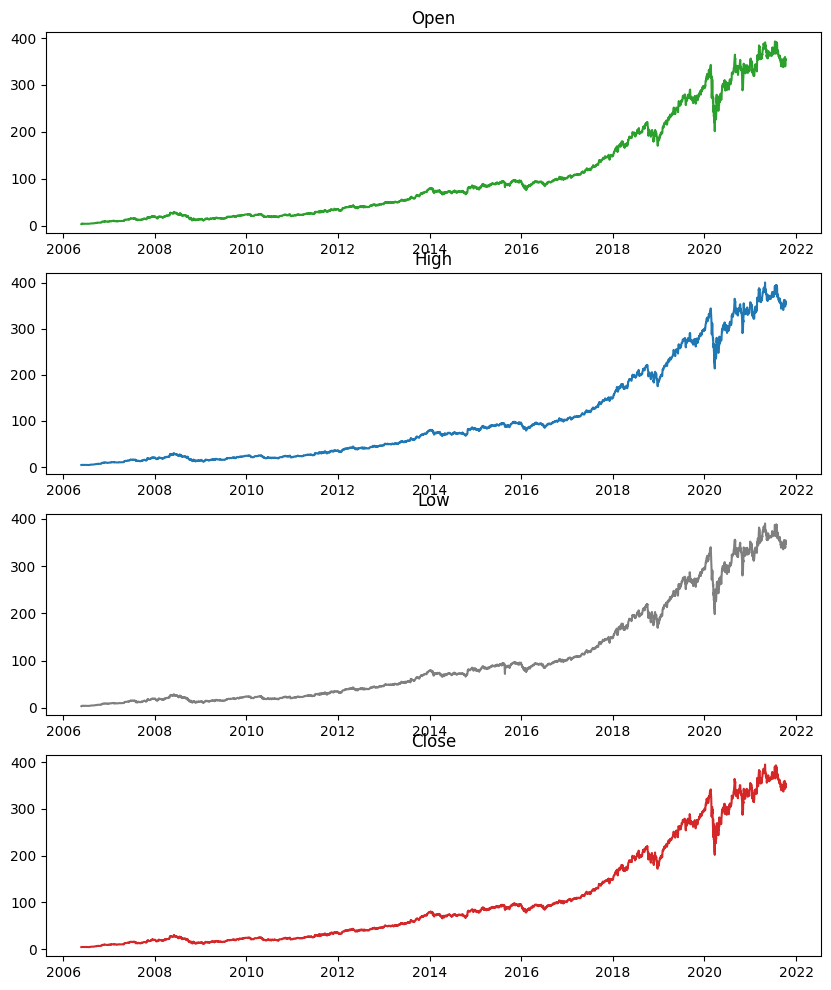

In [3]:
fig, axs = plt.subplots(4, 1,figsize=(10, 12))
axs[0].plot(dataset['Open'],'tab:green')
axs[0].set_title('Open')
axs[1].plot(dataset['High'],'tab:blue')
axs[1].set_title('High')
axs[2].plot(dataset['Low'],'tab:grey')
axs[2].set_title('Low')
axs[3].plot(dataset['Close'],'tab:red')
axs[3].set_title('Close')


The `train_test_split` function divides the dataset into two subsets: `training_set` and `test_set`.

In [4]:
tstart = 2016
tend = 2020

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend+1}":]
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [5]:
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (1259, 4)
test_set shape: (195, 4)


Use the `MinMaxScaler` function to standardize our training set, which will help us avoid the outliers or anomalies.

In [6]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (5036, 1)


Transform back to table format with four features.

In [7]:
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (1259, 4)


In this exercise, we are using `n_steps=50` and `forecasting_horizon=7`. We aim to build a forecasting model capable of predicting `High` stock price seven days ahead based on four features `Open`, `High`, `Low` and `Close`.

In [8]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
n_steps = 50
forecasting_horizon = 7
features = 4
y_index = 1 # the index of High column
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

We are working with multivariate series, so the number of features is four. The number of output is one for `High` stock price. We need to ensure that the shape of `X_train` and `y_train` are compartible with the RNN model.

In [10]:
# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)

In [11]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1203, 50, 4)
y_train shape: (1203, 7, 1)


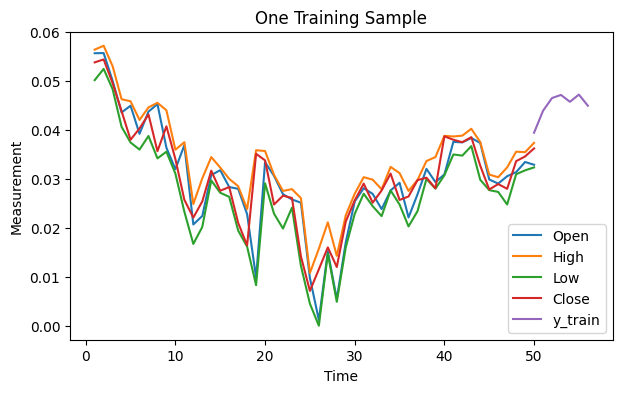

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['Open','High','Low','Close', 'y_train'], loc='lower right')

<a id = "cell_RNN"></a>
## 3. RNN Training

The code for RNN model is the same as Part 1. However, the `features` value is now four for multivariate time series.

In [13]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=7))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 7)                 707       
                                                                 
Total params: 42,707
Trainable params: 42,707
Non-trainable params: 0
_________________________________________________________________


The model will train on 100 epochs with 32 batch sizes. The `epochs` parameter specifies the number of times the model will iterate over the entire training dataset, and the `batch_size` parameter specifies the number of samples that will be used in each iteration.

In [14]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 8s 7ms/step - loss: 0.0188
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 9/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 10/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 11/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 12/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/100
38/38 [=================

<a id = "cell_RNN_test"></a>
## 4. RNN Testing

We are going to repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [15]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)
#Reshape back to orignal format after rescaling
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (139, 50, 4)
y_test shape: (139, 7)


In [16]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the predicted values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('predicted_stock_price shape: ', predicted_stock_price.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)

5/5 [==============================] - 0s 5ms/step
predicted_stock_price shape:  (139, 7)


Next, we evaluate the prediction performance between the true and predicted values. Note, the forecasting peformance tend to decrease when predicting far away forecasting horizons.

In [17]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_stock_price[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 3.98.

Forecasting Horizon: 1 
Mean Absolute Error 6.62.

Forecasting Horizon: 2 
Mean Absolute Error 8.11.

Forecasting Horizon: 3 
Mean Absolute Error 7.77.

Forecasting Horizon: 4 
Mean Absolute Error 7.68.

Forecasting Horizon: 5 
Mean Absolute Error 8.04.

Forecasting Horizon: 6 
Mean Absolute Error 9.87.



Inverse transform the test data to orignal unit for visualization

In [18]:
X_test = X_test.reshape(-1, 50)
X_test = sc.inverse_transform(X_test)
X_test = X_test.reshape(number_test_samples, 50,4)

Visualize the testing and predicted values of each testing time series segment.

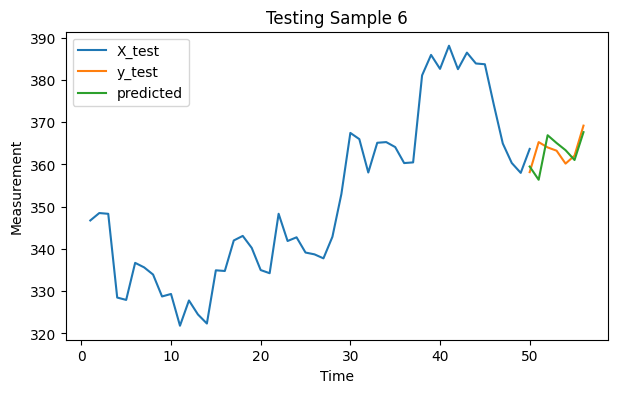

In [19]:
#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 6

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_stock_price[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

Visualize all the real testing values versus the all predicted values based on each forecasting horizon.

In [20]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

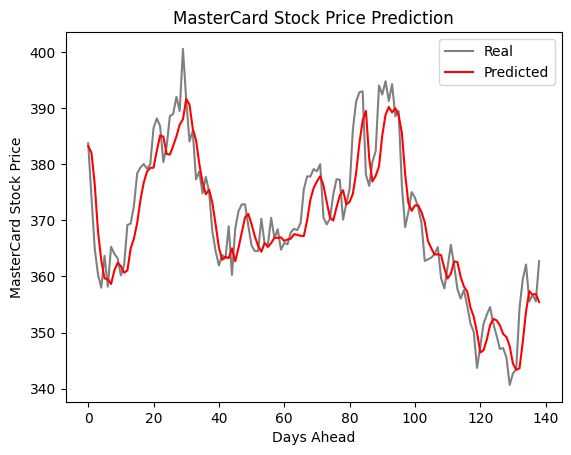

In [21]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_stock_price[:,0])

### References:

***Adapted from:***<br>
*https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network*